In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats
import os

from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
import tensorflow as tf
tf.__version__
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models

In [ ]:
#Load in a model saved from server - should be near best
m = tf.keras.models.load_model('/drive/MyDrive/Colab Notebooks/Thesis Notebooks/wholeBestModel')

In [11]:
classList = ["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

In [6]:
def getDataGen(tfrecordPaths, shuffle=False):
    def decode(serialized_example):
            features = {
                "feature0": tf.io.FixedLenFeature([32000,1], tf.float32),
                "label": tf.io.FixedLenFeature([], tf.int64),
         }
            example = tf.io.parse_single_example(serialized_example, features)

            feature0 = example['feature0']
            label = example['label']
            return (feature0,
                    label)
    
    dataset = tf.data.TFRecordDataset(tfrecordPaths)
    dataset = dataset.map(decode) 
    if shuffle==True:
      dataset = dataset.shuffle(8000) #This ensures all data is shuffled before being outputted
    return dataset

tfRecordsDir = "/drive/MyDrive/Colab Notebooks/Thesis Notebooks/testData/"
testDataFiles = (tfRecordsDir+"fold10/ubs.tfRecord_0",tfRecordsDir+"fold10/ubs.tfRecord_1")
datasetTest = getDataGen(testDataFiles) #datasetTest contains 837 elements, this remains unchanged
batchTest = datasetTest.batch(400, drop_remainder=False)


In [5]:
x_test, y_test = list(datasetTest.batch(1000))[0] #We just take 1000 cuz it's bigger than test set size
x_test = x_test.numpy()
y_test = y_test.numpy()

m.evaluate(x = x_test, y = y_test) #Single MC sample

27/27 [==============================] - 24s 792ms/step - loss: 2555.0039 - accuracy: 0.3990


[2555.00390625, 0.3990442156791687]

In [8]:
mcSampleNo = 50
y_probs = np.mean(np.array([m(x_test, training=False).numpy() for i in range(mcSampleNo)]), axis=0)

In [22]:
sum(np.argmax(y_probs, axis=1) == y_test)/len(y_test)

0.6666666666666666

In [9]:
""" Plot individually the curves
for lab in range(10):
  mapDict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0}
  mapDict[lab]=1
  y_test_bin = [mapDict[i] for i in y_test]
  probs_pos = y_probs[:, lab]

  import sklearn.metrics

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = y_test_bin, y_score = probs_pos, pos_label = 1) #positive class is 1; negative class is 0
  auroc = sklearn.metrics.auc(fpr, tpr)

  display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auroc, 
                                    estimator_name="Positive Class: " + str(lab))
  display.plot()
  plt.grid()

plt.show();
"""

' Plot individually the curves\nfor lab in range(10):\n  mapDict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0}\n  mapDict[lab]=1\n  y_test_bin = [mapDict[i] for i in y_test]\n  probs_pos = y_probs[:, lab]\n\n  import sklearn.metrics\n\n  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = y_test_bin, y_score = probs_pos, pos_label = 1) #positive class is 1; negative class is 0\n  auroc = sklearn.metrics.auc(fpr, tpr)\n\n  display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auroc, \n                                    estimator_name="Positive Class: " + str(lab))\n  display.plot()\n  plt.grid()\n\nplt.show();\n'

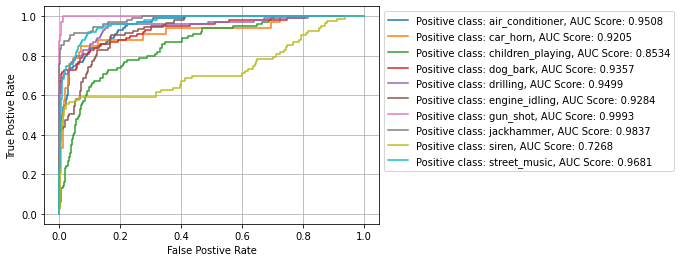

In [17]:
for lab in range(10):
  mapDict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0}
  mapDict[lab]=1
  y_test_bin = [mapDict[i] for i in y_test]
  probs_pos = y_probs[:, lab]

  import sklearn.metrics

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = y_test_bin, y_score = probs_pos, pos_label = 1) #positive class is 1; negative class is 0
  auroc = sklearn.metrics.auc(fpr, tpr)

  plt.plot(fpr,tpr,label="Positive class: " + str(classList[lab]) +", AUC Score: {:.4f}".format(auroc))

plt.legend(bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.xlabel("False Postive Rate")
plt.ylabel("True Postive Rate")
plt.grid()
plt.show();